
## Overview

In this project, we will explore the topic of **Non-negative Matrix Factorization (NMF)**. We will discuss and try some of the fundamental algorithms. 

<!-- We will attempt to beat the performance of these algorithms on certain datasets by either making modifications on them or proposing new ideas.  -->

## Introduction

**Non-negative Matrix Factorization (NMF)** problems were first introduced by Pattero and Tapper [[Paatero and Tapper, 1994]](https://onlinelibrary.wiley.com/doi/abs/10.1002/env.3170050203) in 1994 as "Positive Matrix Factorization" and later reformulated by Lee and Seung [[Lee and Seung, 2000]](https://proceedings.neurips.cc/paper/2000/hash/f9d1152547c0bde01830b7e8bd60024c-Abstract.html). It has been widely studied due to both of its extensive applications in data science and interesting mathematical properties ever since. 

<!-- <span style="color:red">**TODO: Literature Review**</span> -->

We condider the following problem.

[***NMF Problem Statement***] Given a (elementwisely) nonnegative matrix $A \in \mathbb{R}^{m \times n}$ and a positive integer $k < \min\{m,n\}$, find nonnegative matrices $W \in \mathbb{R}^{m \times k}$ and $H \in \mathbb{R}^{k \times n}$ to minimize the functional

\begin{equation}
f(W,H)=\frac{1}{2}\|A-WH\|_F^2.
\tag{1}
\end{equation}


We call the product $WH$ a **non-negative matrix factorization** of $A$. Note that $WH$ is an approximate factorization of $A$ with a rank of at most $k$. In this case, $k$ is a hyperparameter that needs to be tuned for each independent problem.

## Dataset
We will explore the [MNIST](http://yann.lecun.com/exdb/mnist/) database of handwritten digits first. In particular, we will perform NMF on the training data, which is a matrix of nonnegative integers with size $60000 \times 784$. We first load the dataset as an `ndarray` below. The code is adapted from an [official tutorial](https://numpy.org/numpy-tutorials/content/tutorial-deep-learning-on-mnist.html) released by NumPy with modifications being made by the author.


In [23]:
data_sources = {
    "training_images": "train-images-idx3-ubyte.gz",  # 60,000 training images.
    "test_images": "t10k-images-idx3-ubyte.gz",  # 10,000 test images.
    "training_labels": "train-labels-idx1-ubyte.gz",  # 60,000 training labels.
    "test_labels": "t10k-labels-idx1-ubyte.gz",  # 10,000 test labels.
}
headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:10.0) Gecko/20100101 Firefox/10.0"
}
request_opts = {
    "headers": headers,
    "params": {"raw": "true"},
}

import requests
import os

data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

base_url = "https://github.com/rossbar/numpy-tutorial-data-mirror/blob/main/"

for fname in data_sources.values():
    fpath = os.path.join(data_dir, fname)
    if not os.path.exists(fpath):
        print("Downloading file: " + fname)
        resp = requests.get(base_url + fname, stream=True, **request_opts)
        resp.raise_for_status()  # Ensure download was succesful
        with open(fpath, "wb") as fh:
            for chunk in resp.iter_content(chunk_size=128):
                fh.write(chunk)
                
import gzip
import numpy as np

mnist_dataset = {}

# Images
for key in ("training_images", "test_images"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(
            mnist_file.read(), np.uint8, offset=16
        ).reshape(-1, 28 * 28)
# Labels
for key in ("training_labels", "test_labels"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(mnist_file.read(), np.uint8, offset=8)

# split datasets
x_train, y_train, x_test, y_test = (
    mnist_dataset["training_images"],
    mnist_dataset["training_labels"],
    mnist_dataset["test_images"],
    mnist_dataset["test_labels"],
)
assert type(x_train) == type(np.array([1,1]))

## Fundamental Algorithms

In this section we discuss several fundamental numerical algorithms for solving $(1)$. We will implement them and do numerical experiments using Python.

### Multiplicative Update (MU) Algorithm

The first algorithm we see is **Multiplicative Update Algorithm** developed by Lee and Seung [[Lee and Seung, 2000]](https://proceedings.neurips.cc/paper/2000/hash/f9d1152547c0bde01830b7e8bd60024c-Abstract.html). The pseudo-code is provided below. Note that we adopt MATLAB- and Python-style codes for all our pseudocode in this notebook.

~~~
********************** Algorithm 1: Multiplicative Update **********************

MU(A,k,tol,maxit)
    W = rand(m,k)
    H = rand(k,n)
    for i = 1:maxit
        H = H .* (W'*A) ./ (W'*W*H + 1e-9)
        W = W .* (A*H') ./ (W*H*H' + 1e-9)
        if tolerance is satisfied
            break
    return W,H

********************************************************************************
~~~
The 10<sup>-9</sup> term means to avoid being divided by 0. The implementation is provided below.

In [39]:
# multiplicative update implementation
from numpy.linalg import norm

def mu(A,k,tol=1e-6,maxit=1000):
    """
    Algorithm: Multiplicative Update for Nonnegative Matrix Factorization
    
    Input: 
            A - matrix of size (m,n)
            k - rank of the approximate factorization
            tol - tolerance
            maxit - maximal iterations allowed
    
    Output:
            W - left factor of the approximate non-negative matrix factorization
            H - right factor of the approximate non-negative matrix factorization
            error - a list that tracks the variation of the error 
            flag - a boolean value that indicates whether convergence has been reached
    """
    # type casting
    if type(A).__module__ != np.__name__:
        A = np.array(A)
        
    m, n = np.shape(A)
    W = np.random.rand(m,k)
    H = np.random.rand(k,n)
    error = []
    error.append(norm(A - W@H, ord='fro'))
    tol = norm(A, ord='fro') * tol
    
    for i in range(maxit):
        H = (H * (W.T @ A)) / ((W.T @ W) @ H + 1e-9)
        W = (W * (A @ H.T)) / (W @ (H @ H.T) + 1e-9)
        err = norm(A - W@H, ord = 'fro')
        error.append(err)
        if err < tol:
            break
            
    if error[-1] <= tol:
        flag = True
    else:
        flag = False
    
    # error handling
    assert W.shape == (m,k)
    assert H.shape == (k,n)
    
    return W, H, error, flag



### Gradient Descent Algorithms

The next class of NMF algorithms are based on gradient descent methods. The generic framework of gradient descent algorithm is presented below. 

~~~
********************* Algorithm 2: Basic Gradient Descent **********************

gradient-descent(A,k,tol,maxit)
    W = rand(m,k)
    H = rand(k,n)
    for i = 1:maxit
        H = H - epsilon_H * grad_H
        W = W - epsilon_W * grad_W
        if tolerance is satisfied
            break
    return W,H

********************************************************************************
~~~

Often in gradient descent algorithms, a step of projection is added after either $H$ or $W$ is updated. This is to ensure that the target variables stay in the feasible set. The pseudo-code is presented below.

~~~
********************* Algorithm 2: Basic Gradient Descent **********************

gradient-descent(A,k,tol,maxit)
    W = rand(m,k)
    H = rand(k,n)
    for i = 1:maxit
        H = H - epsilon_H * grad_H
        Project H
        W = W - epsilon_W * grad_W
        Project W
        if tolerance is satisfied
            break
    return W,H

********************************************************************************
~~~

In [42]:
# generic code for gradient descent
from numpy.linalg import norm

def gd(A, k, gradH, gradW, epsilon_H=lambda k:1e-3, epsilon_W=lambda k:1e-3, tol=1e-6, maxit=1000):
    """
    Input:
          A - matrix of size (m,n)
          k - rank of the approximate factorization
          gradH - function that computes or approximates the gradient w.r.t. H
          gradW - function that computes or approximates the gradient w.r.t. W
          epsilon_H - rule of choosing step length for gradH, typically depending on iteration number
          epsilon_W - rule of choosing step length for gradW, typically depending on iteration number
          tol - tolerance
          maxit - maximal iterations allowed  
    
    Output:
            W - left factor of the approximate non-negative matrix factorization
            H - right factor of the approximate non-negative matrix factorization
            error - list of Frobenius norm of the difference between A and WH
            flag - a boolean value that indicates whether convergence has been reached
    """
    if type(A).__module__ != np.__name__:
        A = np.array(A)
        
    def project(X):
        return np.maximum(X,np.zeros(np.shape(X)))
    
    m,n = np.shape(A)
    W = np.random.rand(m,k)
    H = np.random.rand(k,n)
    error = []
    error.append(norm(A - W@H, ord='fro'))
    tol = tol * norm(A, ord='fro')
    
    for i in range(maxit):
        H = H - epsilon_H(i) * gradH(A,W,H)
        H = project(H)
        W = W - epsilon_W(i) * gradW(A,W,H)
        W = project(W)
        err = norm(A-W@H,ord='fro')
        error.append(err)
        if err < tol:
            break
            
    if error[-1] <= tol:
        flag = True
    else:
        flag = False
    
    return W, H, error, flag

We look at two algorithms in this class: the steepest descent (SD) algorithm and the coordinate descent (CD) algorithm. We will implement SD but use [scikit-learn](https://scikit-learn.org/stable/index.html) for CD.

We need to derive the gradients of (1) with respect to $W$ and $H$ for SD. To do so, let us remind ourselves some facts regarding the trace operator $Tr(\cdot)$ which maps from $\mathbb{R}^{n \times n}$ to $\mathbb{R}$. 

Suppose in the following formulas, $Tr(\cdot)$ is well-defined for the inputs. We then have

\begin{equation}
\tag{2}
\dfrac{\partial Tr(AXB)}{\partial X} = A^TB^T,
\end{equation} 

\begin{equation}
\tag{3}
\dfrac{\partial Tr(X^TBX)}{\partial X} = BX + B^TX,
\end{equation} 

and

\begin{equation}
\tag{4}
\dfrac{\partial Tr(B^TX^TXB)}{\partial X} = 2XBB^T.
\end{equation} 

With these, we are well-equipped to compute the gradients. Note that by the convention of matrix calculus, we denote the gradients by $\dfrac{\partial f}{\partial W}$ and $\dfrac{\partial f}{\partial H}$ instead of using $\nabla(\cdot)$.

We proceed by rewriting $(1)$ into 

\begin{align}
f(W,H) &= \frac{1}{2}\|A-WH\|_F^2 = \frac{1}{2}Tr\left((A-WH)^T(A-WH)\right)\\
       &= \frac{1}{2}Tr\left(A^TA-A^TWH-H^TW^TA+H^TW^TWH\right).\\
\end{align}

With this and the linearity of $Tr(\cdot)$, we obtain 

\begin{align}
\dfrac{\partial f}{\partial W} &= \frac{1}{2}\left(\dfrac{\partial Tr(H^TW^TWH)}{\partial W} - \dfrac{\partial Tr(A^TWH)}{\partial W} - \dfrac{\partial Tr(H^TW^TA)}{\partial W}\right) \\
&= \frac{1}{2}\left(2WHH^T-AH^T - AH^T\right)\\
&= WHH^T-AH^T \tag{5}
\end{align}

and 

\begin{align}
\dfrac{\partial f}{\partial H} &= \frac{1}{2}\left(\dfrac{\partial Tr(H^TW^TWH)}{\partial H} - \dfrac{\partial Tr(A^TWH)}{\partial H} - \dfrac{\partial Tr(H^TW^TA)}{\partial H}\right) \\
&= \frac{1}{2}\left(2W^TWH-W^TA-W^TA\right)\\
&= W^TWH-W^TA \tag{6}
\end{align}

by applying $(2)$, $(3)$, and $(4)$ accordingly. Now we just need to plug this exact gradient into the framework of the generic gradient descent algorithm. The implementation is provided below.


In [37]:
# Projected Steepest Descent

def sd(A, k, epsilon_H=lambda k:1e-3, epsilon_W=lambda k:1e-3, tol=1e-6, maxit=1000):
    
    def exact_gradH(A,W,H):
        """
        Output: exact gradient w.r.t. H
        """
        return (W.T @ W) @ H - W.T @ A

    def exact_gradW(A,W,H):
        """
        Output: exact gradient w.r.t. W
        """
        return W @ (H @ H.T) - A @ H.T
    
    
    return gd(A,k,exact_gradH, exact_gradW, epsilon_H, epsilon_W, tol, maxit)

For CD, we adopt the framework provided by [scikit-learn](https://scikit-learn.org/stable/index.html).

## Numerical Experiments

We present the numerical results below. To ensure that the notebook runs within 10 minutes, we sample 5000 rows from the training data. 

We first consider MU and CD. We set the rank of the factors to be 650. The maximal number of iterations is set to be 100 and 1000 for CD and MU respectively. 

In [34]:
from sklearn.decomposition import NMF
import time

m,n,rank = 5000, 784, 650
np.random.seed(0)
sample_idx = np.random.randint(0,59999,(m,))
A = x_train[sample_idx,:]

# multiplicative update
model1 = NMF(n_components=rank, solver='mu', init='nndsvda', max_iter=1000, random_state=0)
t0 = time.time()
muW = model1.fit_transform(A)
t1 = time.time()
muH = model1.components_
mu_time = t1-t0

print("-------------result-----------------")
print("multiplicative update")
print("loss: ", model1.reconstruction_err_)
print("relative error: ", model1.reconstruction_err_/np.linalg.norm(A,'fro'))
print("running time: ", mu_time)
print("iteration number: ", model1.n_iter_)
print("------------------------------------")

# coordinate descent
A = x_train[sample_idx,:]
model2 = NMF(n_components=rank, solver='cd', init='nndsvda', max_iter=100, random_state=0)
t2 = time.time()
cdW = model2.fit_transform(A)
t3 = time.time()
cdH = model2.components_
cd_time=t3-t2

print("coordinate descent")
print("loss: ", model2.reconstruction_err_)
print("relative error: ", model2.reconstruction_err_/np.linalg.norm(A,'fro'))
print("running time: ", cd_time)
print("iteration number: ", model2.n_iter_)
print("------------------------------------")

/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


-------------result-----------------
multiplicative update
loss:  11624.01892430597
relative error:  0.06862146906194548
running time:  275.6520960330963
iteration number:  1000
------------------------------------
coordinate descent
loss:  9019.118246857734
relative error:  0.05324364557327393
running time:  247.28826904296875
iteration number:  100
------------------------------------


/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


In the experiment, both methods reached the maximal iterations without reaching the error tolerance. It took about 260 seconds for MU to finish 1000 iterations and 248 seconds for CD to finish 100 iterations. The relative errors of the final result were roughly the same for both algorithms with that of CD slightly better. 

From the result above, we see that while each iteration of CD takes a much longer time, the convergence behaviour is much more favorable than that of MU. 

To get a better idea of this, in the code blocks below, we increase the maximal iteration number from 100 and 1000 to 200 and 2000. This time, the MU algorithm stopped at the 1250-th iteration (by reaching a stationary point), but the relative error is still fairly large. In contrast, the CD algorithm finished all the 200 iterations and achieved a much lower relative error and loss compared to the 100-iteration case. (**Re-running this would take more than 15 minutes.**)

In [36]:
from sklearn.decomposition import NMF
import time

m,n,rank = 5000, 784, 650
np.random.seed(0)
sample_idx = np.random.randint(0,59999,(m,))
A = x_train[sample_idx,:]

# multiplicative update
model11 = NMF(n_components=rank, solver='mu', init='random', max_iter=2000, random_state=0)
t00 = time.time()
muW2 = model11.fit_transform(A)
t11 = time.time()
muH2 = model11.components_
mu_time2 = t11-t00

# coordinate descent
A = x_train[sample_idx,:]
model22 = NMF(n_components=rank, solver='cd', init='random', max_iter=200, random_state=0)
t22 = time.time()
cdW2 = model22.fit_transform(A)
t33 = time.time()
cdH2 = model22.components_
cd_time2=t33-t22

print("-------------result-----------------")
print("multiplicative update")
print("loss: ", model11.reconstruction_err_)
print("relative error: ", model11.reconstruction_err_/np.linalg.norm(A,'fro'))
print("running time: ", mu_time2)
print("iteration number: ", model11.n_iter_)
print("------------------------------------")
print("coordinate descent")
print("loss: ", model22.reconstruction_err_)
print("relative error: ", model22.reconstruction_err_/np.linalg.norm(A,'fro'))
print("running time: ", cd_time2)
print("iteration number: ", model22.n_iter_)

-------------result-----------------
multiplicative update
loss:  11120.690804286422
relative error:  0.06565011163033403
running time:  340.06663608551025
iteration number:  1250
------------------------------------
coordinate descent
loss:  7160.705452356724
relative error:  0.0422726537921513
running time:  495.76175594329834
iteration number:  200


/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In fact, if we use the MU algorithm implemented on our own and plot the error, we see that after certain iterations, the algorithm becomes not as effective.

Text(0.5, 1.0, 'Loss with MU')

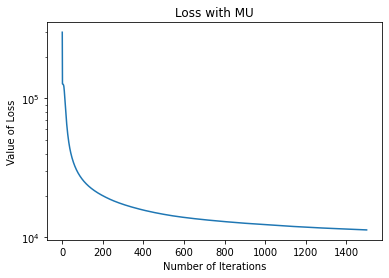

In [40]:
import matplotlib.pyplot as plt

m,n,k = 5000, 784, 650
maxit = 1500
np.random.seed(0)
sample_idx = np.random.randint(0,59999,(m,))
A = x_train[sample_idx,:]
W_mu,H_mu,error_mu,_ = mu(A,k,maxit=maxit)
plt.semilogy(error_mu)
plt.xlabel("Number of Iterations")
plt.ylabel("Value of Loss")
plt.title("Loss with MU")

Before moving on to steepest descent, we comment that gradient descent methods are generally very slow to converge (if they converge at all)[[Berry et al., 2006]](https://ieeexplore.ieee.org/abstract/document/4634046). To have a nicely-working gradient descent algorithm, the step size has to be carefully chosen.

As such, we tested many different rule of step sizes, including $\dfrac{1}{2^k}$ where $k$ is the number of iteration where the algorithm is currently at, 0.001, 0.01, $\dfrac{1}{2^{20}}$. As it turns out, the step size that worked the best among all the tested ones was $\dfrac{1}{2^{18}}$. This is purely heuristic, but it actually worked fine. The result is presented below. By plotting the errors given by this together with those given by MU, we see that MU still works better than SD with this "carefully chosen" heuristic step size.

In [57]:
# steepest descent experiments
m,n,k = 5000, 784, 650
np.random.seed(0)
sample_idx = np.random.randint(0,59999,(m,))
A = x_train[sample_idx,:]
epsilon = lambda k: 1/(2**18)
# def epsilon(k):
#     return 1/(2**k)
k = 650
tol=1e-5
maxit = 1000
W,H,error_sd,flag = sd(A,k,epsilon,epsilon,tol=tol,maxit=maxit)


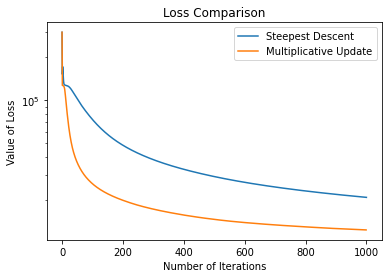

In [63]:
import matplotlib.pyplot as plt
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.semilogy(error_sd,label="Steepest Descent")
ax.semilogy(error_mu[:1000],label="Multiplicative Update")
plt.xlabel("Number of Iterations")
plt.ylabel("Value of Loss")
plt.title("Loss Comparison")
ax.legend(loc='best')